### Домашняя работа к уроку 2

#### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [1]:
import pandas as pd
import numpy as np
import re

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                                precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# новости
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
# Загрузим пользователей и списки последних прочитанных новостей
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [8]:
#import nltk
#nltk.download('stopwords')

In [9]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)
morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-12-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.3 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 14s


In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
common_dictionary[10]

'ватутин'

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 30.9 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.22822155), (16, 0.72577876), (24, 0.026309079)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: продукция турция восток километр турецкий обвинить израиль
topic_1: россия президент это газ сша путин год
topic_2: выдавать кость понятие прожить армения заполнить критиковать
topic_3: австралия адмирал дональд диск ирландия вырабатывать показ
topic_4: компания год млн доллар налог производитель планета
topic_5: экипаж северный иран рейтинг место южный флот
topic_6: наука вирус кровь это последствие великобритания британский
topic_7: станция операция город год житель смерть день
topic_8: обнаружить товар участок аэропорт катастрофа авария произойти
topic_9: пациент торговый женщина городской белоруссия белорусский девочка
topic_10: банк млрд год экономика экономический это украина
topic_11: который это год исследование nn россия работа
topic_12: погибнуть одежда маршрут горожанин надпись километр аргентина
topic_13: ракета жертва тело земля убить штат удар
topic_14: поверхность физика вино научный определение мэй лауреат
topic_15: мозг мужчина тело жизнь свой год страдать
top

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.083079,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.041518
1,4896,0.0,0.0,0.0,0.0,0.262307,0.0,0.0,0.0,0.0,...,0.0,0.338657,0.0,0.264958,0.0,0.0,0.0,0.0,0.0,0.113060
2,4897,0.0,0.0,0.0,0.0,0.228201,0.0,0.0,0.0,0.0,...,0.0,0.725769,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.026339
3,4898,0.0,0.0,0.0,0.0,0.102842,0.0,0.0,0.0,0.0,...,0.0,0.886257,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,4899,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.481733,0.0,0.0,0.0,0.0,0.0,0.492698


In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.27057624, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0208506 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02084984, 0.        , 0.10409028, 0.        , 0.04223783,
       0.        , 0.49795955, 0.        , 0.        , 0.03249381])

In [26]:
user_articles_list = users['articles'].iloc[33]

In [27]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding(user_articles_list)

array([0.01207385, 0.18901135, 0.        , 0.        , 0.00537524,
       0.00664061, 0.01699933, 0.00887723, 0.        , 0.0038637 ,
       0.04745031, 0.07396485, 0.        , 0.0017332 , 0.        ,
       0.        , 0.09031201, 0.08852805, 0.        , 0.04657171,
       0.        , 0.08767128, 0.11796169, 0.02462457, 0.16985184])

In [29]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [30]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

In [31]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.052595,0.0,0.011896,0.0,0.000000,0.000000,0.035292,0.000000,...,0.012332,0.052091,0.053144,0.012661,0.045046,0.000000,0.253608,0.052465,0.000000,0.245375
1,u108690,0.0,0.134184,0.0,0.000000,0.0,0.000000,0.016468,0.008054,0.007519,...,0.008224,0.163389,0.076001,0.009602,0.003747,0.004755,0.061384,0.134375,0.035322,0.159490
2,u108339,0.0,0.142567,0.0,0.000000,0.0,0.001787,0.006917,0.073268,0.039443,...,0.006788,0.100050,0.092746,0.007711,0.025520,0.000000,0.025023,0.149006,0.011743,0.107690


In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.052595,0.0,0.011896,0.0,0.000000,0.000000,0.035292,0.000000,...,0.052091,0.053144,0.012661,0.045046,0.000000,0.253608,0.052465,0.000000,0.245375,0
1,u108690,0.0,0.134184,0.0,0.000000,0.0,0.000000,0.016468,0.008054,0.007519,...,0.163389,0.076001,0.009602,0.003747,0.004755,0.061384,0.134375,0.035322,0.159490,1
2,u108339,0.0,0.142567,0.0,0.000000,0.0,0.001787,0.006917,0.073268,0.039443,...,0.100050,0.092746,0.007711,0.025520,0.000000,0.025023,0.149006,0.011743,0.107690,1


In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.2577939 , 0.01432309, 0.36545455, 0.1245065 , 0.04223699,
       0.12555774, 0.11482449, 0.01966294, 0.02458204, 0.22409146])

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.262504, F-Score=0.700, Precision=0.665, Recall=0.739


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1664   91]
 [  65  180]]


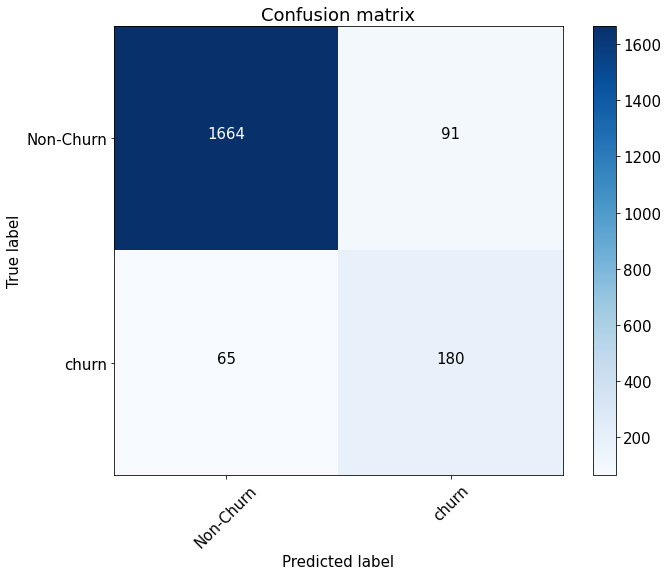

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_2.png")
plt.show()

In [41]:
roc_auc_score(y_test, preds)

0.948152799581371

#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [42]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [43]:
get_user_embedding(user_articles_list)

array([0.        , 0.15076939, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00530375, 0.        , 0.        ,
       0.01850755, 0.07978544, 0.        , 0.        , 0.        ,
       0.        , 0.06061412, 0.04462598, 0.        , 0.        ,
       0.        , 0.04697796, 0.13909633, 0.        , 0.18688421])

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010425,0.00000,...,0.0,0.000000,0.000000,0.0,0.031568,0.0,0.268822,0.000000,0.000000,0.141842
1,u108690,0.0,0.110533,0.0,0.0,0.0,0.0,0.014172,0.000000,0.00000,...,0.0,0.161843,0.049927,0.0,0.000000,0.0,0.063005,0.087656,0.020961,0.190705
2,u108339,0.0,0.080230,0.0,0.0,0.0,0.0,0.000000,0.072976,0.01397,...,0.0,0.079604,0.090928,0.0,0.000000,0.0,0.000000,0.139626,0.009015,0.112735


In [45]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010425,0.00000,...,0.000000,0.000000,0.0,0.031568,0.0,0.268822,0.000000,0.000000,0.141842,0
1,u108690,0.0,0.110533,0.0,0.0,0.0,0.0,0.014172,0.000000,0.00000,...,0.161843,0.049927,0.0,0.000000,0.0,0.063005,0.087656,0.020961,0.190705,1
2,u108339,0.0,0.080230,0.0,0.0,0.0,0.0,0.000000,0.072976,0.01397,...,0.079604,0.090928,0.0,0.000000,0.0,0.000000,0.139626,0.009015,0.112735,1


In [46]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [47]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [48]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15272235, 0.02651163, 0.42273066, 0.17718478, 0.03226653,
       0.0682357 , 0.09445833, 0.02784726, 0.02527041, 0.1087706 ])

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.258025, F-Score=0.677, Precision=0.606, Recall=0.767


Confusion matrix, without normalization
[[1633  122]
 [  58  187]]


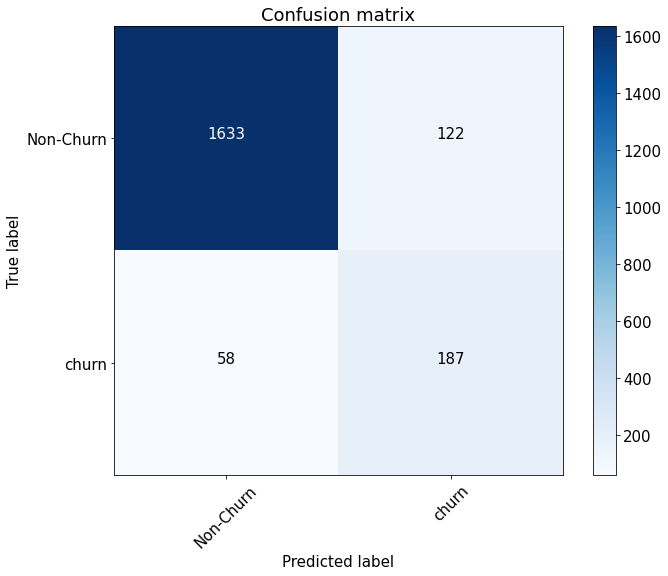

In [50]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_2.png")
plt.show()

In [51]:
roc_auc_score(y_test, preds)

0.9470852956567243

#### 3. Повторить п.2, но используя уже не медиану, а max

In [52]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [53]:
get_user_embedding(user_articles_list)

array([0.0724431 , 0.41728055, 0.        , 0.        , 0.02005817,
       0.02707664, 0.0838036 , 0.02930944, 0.        , 0.02318222,
       0.1619577 , 0.16053908, 0.        , 0.01039923, 0.        ,
       0.        , 0.2972106 , 0.34636241, 0.        , 0.19606885,
       0.        , 0.2909568 , 0.27677459, 0.11968637, 0.34334376])

In [54]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.270576,0.0,0.071374,0.0,0.000000,0.000000,0.119110,0.000000,...,0.053139,0.197343,0.214773,0.045608,0.164899,0.000000,0.497960,0.205244,0.000000,0.839037
1,u108690,0.0,0.375458,0.0,0.000000,0.0,0.000000,0.039631,0.030829,0.023236,...,0.049346,0.324131,0.262065,0.057615,0.022484,0.028532,0.127222,0.371150,0.115477,0.298564
2,u108339,0.0,0.443238,0.0,0.000000,0.0,0.010721,0.041501,0.183646,0.143966,...,0.021142,0.190404,0.173499,0.023520,0.122921,0.000000,0.135968,0.265288,0.028633,0.207797


In [55]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.270576,0.0,0.071374,0.0,0.000000,0.000000,0.119110,0.000000,...,0.197343,0.214773,0.045608,0.164899,0.000000,0.497960,0.205244,0.000000,0.839037,0
1,u108690,0.0,0.375458,0.0,0.000000,0.0,0.000000,0.039631,0.030829,0.023236,...,0.324131,0.262065,0.057615,0.022484,0.028532,0.127222,0.371150,0.115477,0.298564,1
2,u108339,0.0,0.443238,0.0,0.000000,0.0,0.010721,0.041501,0.183646,0.143966,...,0.190404,0.173499,0.023520,0.122921,0.000000,0.135968,0.265288,0.028633,0.207797,1


In [56]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [58]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.14683938e-01, 1.91921892e-05, 7.19781033e-01, 1.53655314e-01,
       3.19525158e-02, 4.02249861e-02, 1.15429837e-01, 4.71922392e-04,
       2.95704835e-03, 1.04153669e-01])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.314614, F-Score=0.782, Precision=0.730, Recall=0.841


Confusion matrix, without normalization
[[1679   76]
 [  40  205]]


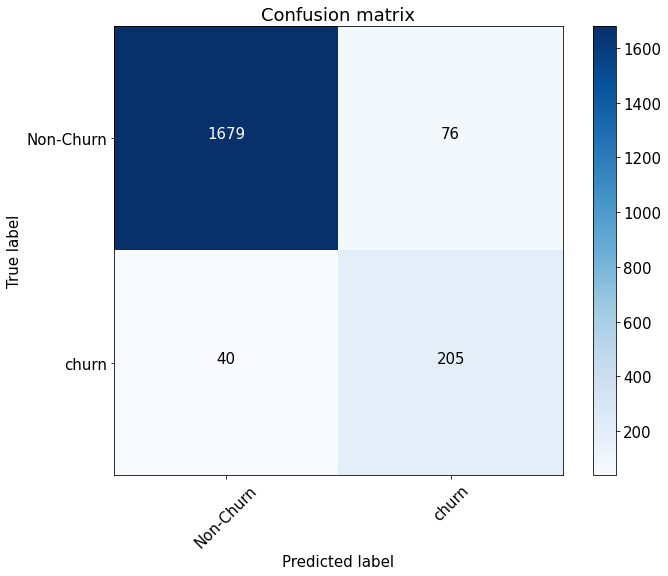

In [61]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_2.png")
plt.show()

In [62]:
roc_auc_score(y_test, preds)

0.9724890982033839

#### 4. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [80]:
# создаём пустой ДатаФрейм
df = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'f_score'])

In [81]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'mean', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)

Best Threshold=0.262504, F-Score=0.700, Precision=0.665, Recall=0.739


In [82]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'median', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)

Best Threshold=0.258025, F-Score=0.677, Precision=0.606, Recall=0.767


In [83]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'max', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)

Best Threshold=0.314614, F-Score=0.782, Precision=0.730, Recall=0.841


In [84]:
df

,model,roc_auc,precision,f_score
0,mean,0.948153,0.665441,0.700193
1,median,0.947085,0.606452,0.677477
2,max,0.972489,0.730496,0.781784


#### 5. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

##### Выводы: метод получения эмбеддингов пользователей MAX оказался эффективнее остальных т.к. при этом методе пики распределения не размываются, а напротив, подчеркиваются что в данном случае оказалось эффективнее. 

##### Предположение: возможно при другом объёме и содержании текста более эффективными окажутся "сглаживающие" методы.